In [9]:
import sys
from pathlib import Path

repo_root = Path.cwd().parent  # adjust" if notebook lives in notebooks/
print(repo_root)
sys.path.insert(0,str(repo_root/"src"))

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import map_coordinates
from scipy.interpolate import RegularGridInterpolator
from IPython.display import HTML
from IPython.display import display, Video

from KPZ_solver import KPZSolver
from KPZ_visualizations import * #sample_line, plot_1d_line, sample_plane, plot_2d_heatmap, animate_2d_heatmap, plot_3d_surface, plot_gradient_magnitude

/home/cmurthy/Documents/computational_physics/gproject2


# Test KPZ

T = 1.0
L2 error   = 1.969e-05
Max error  = 2.785e-05


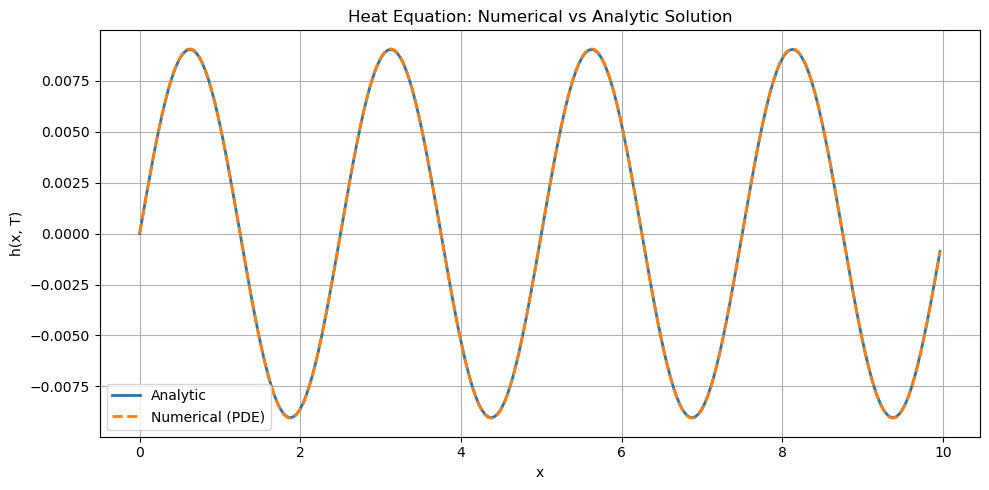

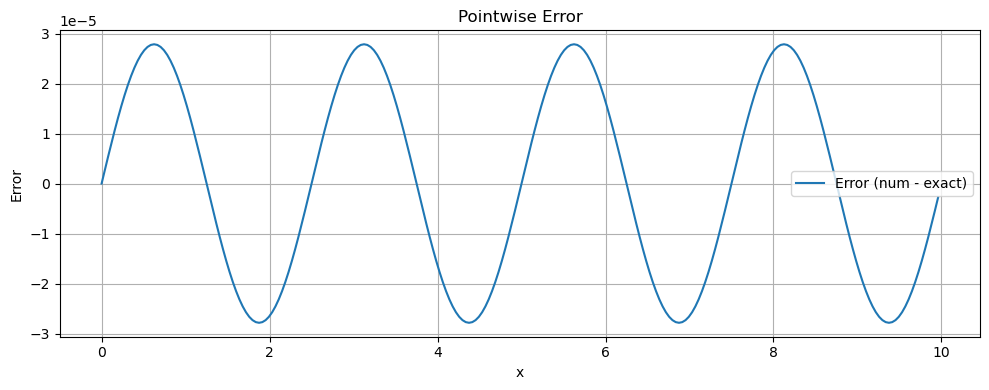

In [4]:
# KPZ setup
L = 10.0
N = 256
dt = 1e-4
T = 1.0
nu = 1.0

# We will test it against an analytical solution so these will be zero
lam = 0.0
noise_strength = 0.0

# Initial condition
m = 4                     
k = 2.0 * np.pi * m / L   
A = 5.0                   
def init_1d(x):
    return A * np.sin(k * x)

# Set it up
solver = KPZSolver(
    L=L,
    N=N,
    dt=dt,
    d=1,
    nu=nu,
    lam=lam,
    noise_strength=noise_strength,
    initial_condition=init_1d,
)

# Run it
snapshots = solver.run(T=T, store_interval=None)

# analytical solution to test against
num_steps = int(T / dt)
t_num = num_steps * dt
x = solver.coords[0]  # 1D grid
h_exact = A * np.exp(-nu * k**2 * t_num) * np.sin(k * x)


h_num = solver.get_height()
l2_error = np.sqrt(np.mean((h_num - h_exact)**2))
max_error = np.max(np.abs(h_num - h_exact))

print(f"T = {t_num}")
print(f"L2 error   = {l2_error:.3e}")
print(f"Max error  = {max_error:.3e}")

#Plot
plt.figure(figsize=(10, 5))
plt.plot(x, h_exact, label="Analytic", linewidth=2)
plt.plot(x, h_num, "--", label="Numerical (PDE)", linewidth=2)
plt.title("Heat Equation: Numerical vs Analytic Solution")
plt.xlabel("x")
plt.ylabel("h(x, T)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(x, h_num - h_exact, label="Error (num - exact)")
plt.title("Pointwise Error")
plt.xlabel("x")
plt.ylabel("Error")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Original Fake solver test

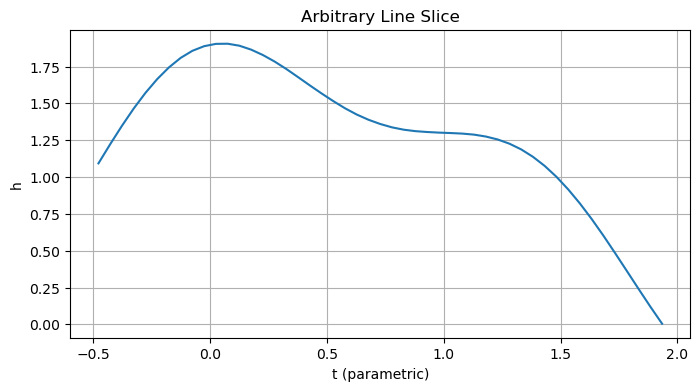

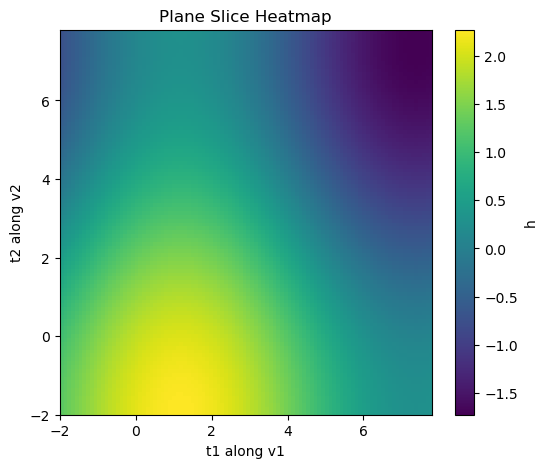

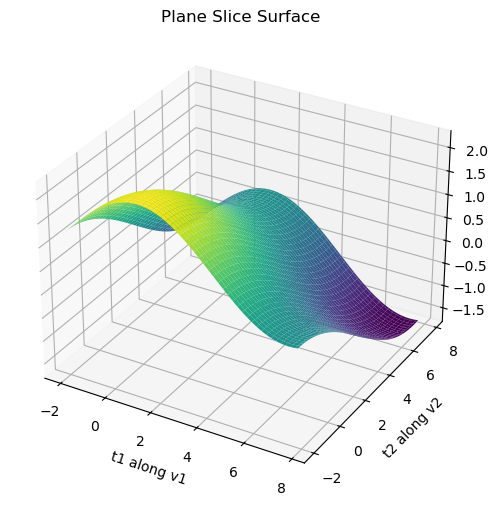

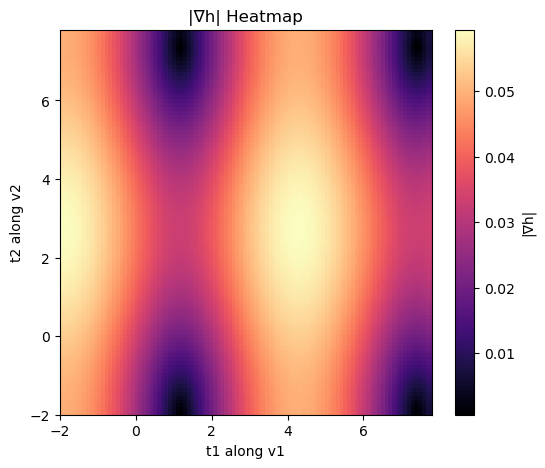

In [7]:
# Create a fake KPZ solver with 2D domain
class FakeSolver:
    def __init__(self):
        self.d = 3
        self.L = (10,10,10)
        self.N = (50,50,50)

        xs = np.linspace(0,10,50,endpoint=False)
        ys = np.linspace(0,10,50,endpoint=False)
        zs = np.linspace(0,10,50,endpoint=False)

        self.coords = np.meshgrid(xs, ys, zs, indexing='ij')

        # Fake height field
        X, Y, Z = self.coords
        self.h = np.sin(X/2) + np.cos(Y/3) + 0.3*np.sin(Z)

solver = FakeSolver()

num_snapshots = 10
snapshots = [solver.h + 0.05*i for i in range(num_snapshots)]

x0 = [2,2,2]              # center of domain
v = [3,0,4]              # arbitrary direction

t_vals, h_vals, X = sample_line(solver.h, solver.coords, x0, v, t_range=5)
plot_1d_line(t_vals, h_vals, "Arbitrary Line Slice")

x0 = [2,2,2]
v1 = [1,0,0]
v2 = [0,1,0]

t_range = 10
t1_vals, t2_vals, h_plane, X_plane = sample_plane(solver.h, solver.coords, x0, v1, v2, t1_range=t_range, t2_range=t_range)

# 2D Heatmap
plot_2d_heatmap(h_plane, t1_vals, t2_vals, "Plane Slice Heatmap")

# 3D Surface
plot_3d_surface(h_plane, t1_vals, t2_vals, "Plane Slice Surface")

# Gradient magnitude
plot_gradient_magnitude(h_plane, t1_vals, t2_vals, "|∇h| Heatmap")

Collected 20 snapshots


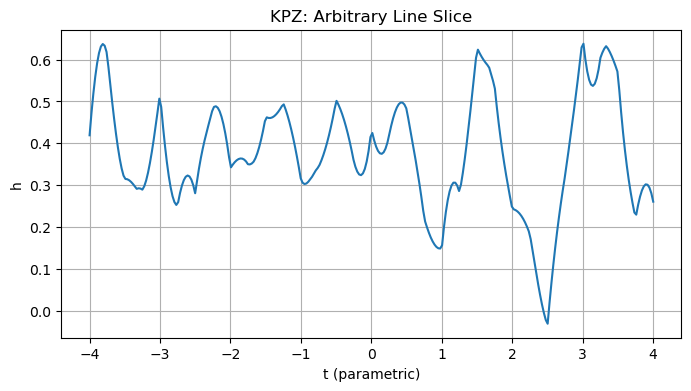

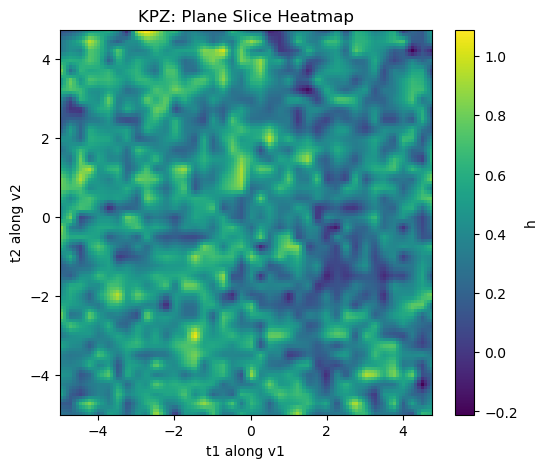

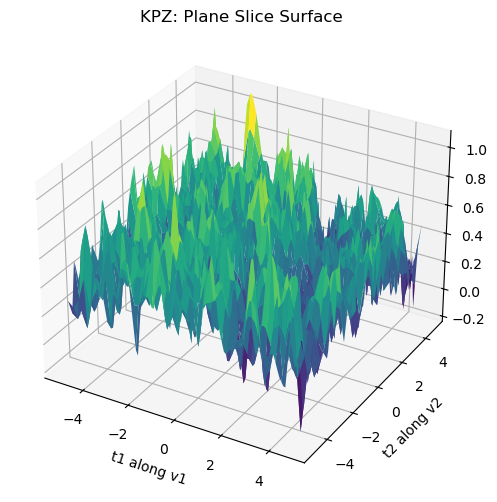

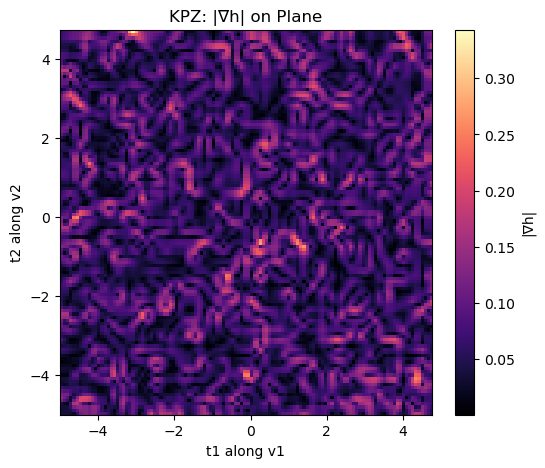

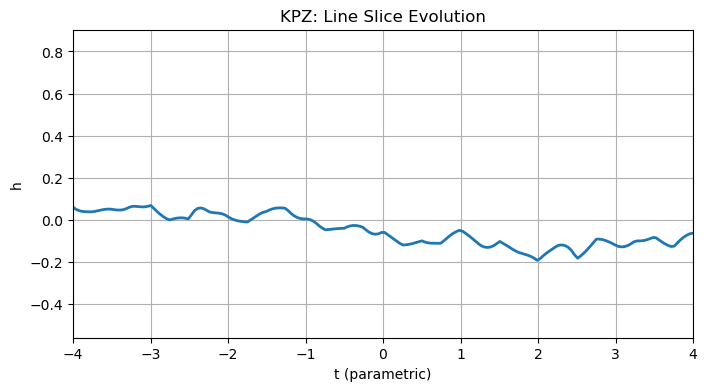

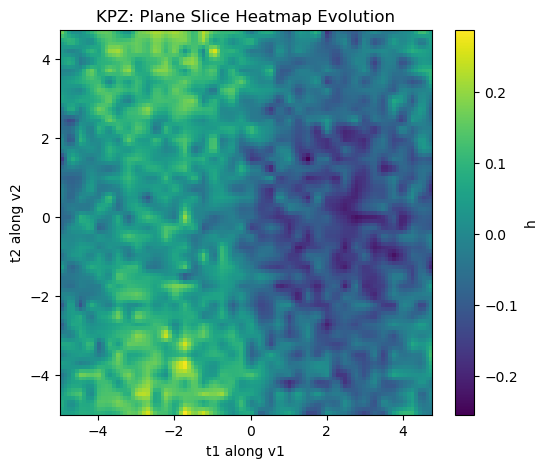

In [13]:
# -----------------------------
# Example: KPZ in 3D, then use your sampling + plotting functions
# -----------------------------

# --- KPZ setup ---
L = (10.0, 10.0, 10.0)     # 3D domain
N = (40, 40, 40)           # resolution (keep modest so it runs fast)
dt = 5e-4
T = 0.5                    # final time
nu = 1.0
lam = 2.0
noise_strength = 0.3
d = 3

# Initial condition: small random perturbation around flat
def init_3d(x, y, z):
    return 0.1 * np.sin(2*np.pi*x/L[0]) + 0.05 * np.cos(2*np.pi*y/L[1]) \
           + 0.02 * np.random.default_rng(0).standard_normal(x.shape)

solver = KPZSolver(
    L=L,
    N=N,
    dt=dt,
    d=d,
    nu=nu,
    lam=lam,
    noise_strength=noise_strength,
    initial_condition=init_3d,
)

# Run and collect snapshots for possible animations
store_interval = 50
snapshots = solver.run(T=T, store_interval=store_interval)
coords = solver.coords

print(f"Collected {len(snapshots)} snapshots")

# Use the last snapshot for static slices
h_last = snapshots[-1]

# -----------------------------
# 1D line slice through the KPZ field
# -----------------------------
x0 = [L[0]/2, L[1]/2, L[2]/2]   # center of domain
v  = [1.0, 0.5, -0.3]           # arbitrary direction

t_vals, h_vals, X_line = sample_line(
    h_last,
    coords,
    x0=x0,
    v=v,
    num_points=300,
    t_range=4.0,
)

plot_1d_line(t_vals, h_vals, title="KPZ: Arbitrary Line Slice")

# -----------------------------
# 2D plane slice through the KPZ field
# -----------------------------
x0_plane = [L[0]/2, L[1]/2, L[2]/2]  # center again
v1 = [1.0, 0.0, 0.0]                 # along x
v2 = [0.0, 1.0, 0.0]                 # along y

t_range = 5.0   # parametric range along v1, v2
t1_vals, t2_vals, h_plane, X_plane = sample_plane(
    h_last,
    coords,
    x0=x0_plane,
    v1=v1,
    v2=v2,
    n1=120,
    n2=120,
    t1_range=t_range,
    t2_range=t_range,
)

# 2D heatmap
plot_2d_heatmap(h_plane, t1_vals, t2_vals, title="KPZ: Plane Slice Heatmap")

# 3D surface
plot_3d_surface(h_plane, t1_vals, t2_vals, title="KPZ: Plane Slice Surface")

# Gradient magnitude heatmap
plot_gradient_magnitude(h_plane, t1_vals, t2_vals, title="KPZ: |∇h| on Plane")

# -----------------------------
# Optional: animations over time (using your animation helpers)
# -----------------------------

# Build line slices over all snapshots for 1D animation
t_vals_list = []
h_vals_list = []
for h_snap in snapshots:
    t_tmp, h_tmp, _ = sample_line(h_snap, coords, x0, v, num_points=200, t_range=4.0)
    t_vals_list.append(t_tmp)
    h_vals_list.append(h_tmp)

anim1d = animate_1d(t_vals_list, h_vals_list, title="KPZ: Line Slice Evolution", interval=150)

# Build plane slices over all snapshots for 2D heatmap animation
h_planes_list = []
for h_snap in snapshots:
    _, _, h_pl, _ = sample_plane(h_snap, coords, x0_plane, v1, v2,
                                 n1=100, n2=100,
                                 t1_range=t_range, t2_range=t_range)
    h_planes_list.append(h_pl)

anim2d = animate_2d_heatmap(h_planes_list, t1_vals, t2_vals,
                            title="KPZ: Plane Slice Heatmap Evolution",
                            interval=150)
HTML(anim1d.to_jshtml())
HTML(anim2d.to_jshtml())

# If you want animated 3D surface (heavier to render):
# anim3d = animate_3d_surface(h_planes_list, t1_vals, t2_vals,
#                             title="KPZ: Plane Slice Surface Evolution",
#                             interval=200)

In [ ]:
HTML(anim1d.to_jshtml())

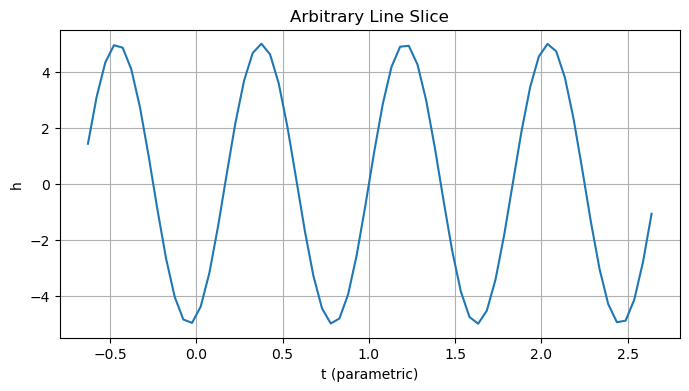

In [11]:
# KPZ setup
L = 10.0
N = 256
dt = 1e-4
T = 1.0
nu = 1.0

# We will test it against an analytical solution so these will be zero
lam = 5.0
noise_strength = 1.0

# Initial condition
m = 4                     
k = 2.0 * np.pi * m / L   
A = 5.0                   
def init_1d(x):
    return A * np.sin(k * x)

# Set it up
solver = KPZSolver(
    L=L,
    N=N,
    dt=dt,
    d=1,
    nu=nu,
    lam=lam,
    noise_strength=noise_strength,
    initial_condition=init_1d,
)

x0 = [2]              # center of domain
v = [3]              # arbitrary direction

t_vals, h_vals, X = sample_line(solver.h, solver.coords, x0, v, t_range=5)
plot_1d_line(t_vals, h_vals, "Arbitrary Line Slice")